In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
import os
import cv2
import imutils
from tqdm import tqdm
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
random.seed(5016)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import shutil
#shutil.rmtree('./data_word_face_train')
#shutil.rmtree('./data_word_face_test')
#shutil.rmtree('./data_word_face_dev')

In [4]:
!unzip '/content/drive/MyDrive/cv_data/data_word_face_train.zip' -d '/content'
!unzip '/content/drive/MyDrive/cv_data/data_word_face_test.zip' -d '/content'
!unzip '/content/drive/MyDrive/cv_data/data_word_face_dev.zip' -d '/content'

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/data_word_face_test/F09/words/02/10/color_001_face.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_002.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_002_face.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_003.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_003_face.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_004.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_004_face.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_005.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_005_face.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_006.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_006_face.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/color_007.jpg  
  inflating: /content/data_word_face_test/F09/words/02/10/col

In [2]:
def extract_data_path(path = './data_word' , words_or_phrases = 'words' , face=False):
    X_image_seq = []
    y_class = []
    person_ids = [x for x in os.listdir(path) if x[-3:] != 'txt']
    counter = 0
    
    for p_id in person_ids:
        if p_id=='.ipynb_checkpoints':
            continue

        word_or_phrase_type_path = path + '/' + p_id + '/' + words_or_phrases        
        word_or_phrase_ids = os.listdir(word_or_phrase_type_path)
        
        for w_p_id in word_or_phrase_ids:
            word_or_phrase_instance_path = word_or_phrase_type_path + '/' + w_p_id
            instance_ids =  os.listdir(word_or_phrase_instance_path)
            
            for i_id in instance_ids:
                images = os.listdir(word_or_phrase_instance_path + '/' + i_id)

                if face:
                    color_images = [x for x in images if x[-8:-4] == 'face']
                else:
                    color_images = [x for x in images if x[-8:-4] != 'face']

                image_seq = []
                for c_image in color_images:
                    c_image_path = word_or_phrase_instance_path + '/' + i_id + '/' + c_image                    
                    
                    current_image = cv2.imread(c_image_path)
                    image_seq.append(current_image)
                    #image_seq.append(c_image_path)
                    
                X_image_seq.append(image_seq)
                y_class.append(int(w_p_id)-1)

                #if (counter+1) % 200 == 0:
                    #print("Iteration: " + str(1+counter))
                counter += 1
        
    return X_image_seq, y_class

def data_resize(X, data_width = 64):
    for i, img_seq in enumerate(X):   
        for j, img in enumerate(img_seq):           
            X[i][j] = X[i][j][4:data_width+4, 4:data_width+4, :]     
    return X

def data_padding(X, data_len = 15):
    for i, img_seq in enumerate(X):        
        if len(img_seq) < data_len:
            pad_img = img_seq[len(img_seq)-1]
            n = data_len-len(img_seq)
            X[i].extend([pad_img]*n)
        elif len(img_seq) > data_len:
            X[i] = X[i][:data_len]           
    return X

def data_aug_flip(img):
  return cv2.flip(img, 1)

def data_aug_brightness(img, low=0.5, high=2):
  value = random.uniform(low, high)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img = np.array(img, dtype = np.float64)
  img[:,:,1] = img[:,:,1]*value
  img[:,:,1][img[:,:,1]>255] = 255
  img[:,:,2] = img[:,:,2]*value
  img[:,:,2][img[:,:,2]>255] = 255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  return img

def data_aug_channel_shift(img, value=60):
  value = int(random.uniform(-value, value))
  img = img + value
  img[:,:,:][img[:,:,:]>255]  = 255
  img[:,:,:][img[:,:,:]<0]  = 0
  img = img.astype(np.uint8)
  return img

def data_aug_all(X, y):
    X_face_aug_flip = []
    for img_seq in X:
      seq = []
      for img in img_seq:
        seq.append(data_aug_flip(img))
      X_face_aug_flip.append(seq)

    X_face_aug_brightness = []
    for img_seq in X:
      seq = []
      for img in img_seq:
        seq.append(data_aug_brightness(img))
      X_face_aug_brightness.append(seq)

    X_face_aug_channel_shift = []
    for img_seq in X:
      seq = []
      for img in img_seq:
        seq.append(data_aug_channel_shift(img))
      X_face_aug_channel_shift.append(seq)

    y_aug_flip = y[:]
    y_aug_brightness = y[:]
    y_aug_channel_shift = y[:]
    
    return X_face_aug_flip, X_face_aug_brightness, X_face_aug_channel_shift, y_aug_flip, y_aug_brightness, y_aug_channel_shift

In [3]:
train_path = './data_word_face_train'
test_path = './data_word_face_test'
dev_path = './data_word_face_dev'

X_face_test, y_test = extract_data_path(path=test_path, face=True)
X_face_test = data_resize(X_face_test)
X_face_test = data_padding(X_face_test)
X_test = np.array(X_face_test[:])
y_test = np.array(y_test[:])


X_face_dev, y_dev = extract_data_path(path=dev_path, face=True)
X_face_dev = data_resize(X_face_dev)
X_face_dev = data_padding(X_face_dev)
X_dev = np.array(X_face_dev[:])
y_dev = np.array(y_dev[:])


X_face_train, y_train = extract_data_path(path=train_path, face=True)
X_face_train = data_resize(X_face_train)
X_face_train = data_padding(X_face_train)
X_face_aug_flip_train, X_face_aug_brightness_train, X_face_aug_channel_shift_train, y_aug_flip_train, y_aug_brightness_train, y_aug_channel_shift_train = data_aug_all(X_face_train, y_train)

X_face_train.extend(X_face_aug_flip_train)
X_face_train.extend(X_face_aug_brightness_train)
X_face_train.extend(X_face_aug_channel_shift_train)
X_train = np.array(X_face_train[:])

y_train.extend(y_aug_flip_train)
y_train.extend(y_aug_brightness_train)
y_train.extend(y_aug_channel_shift_train)
y_train = np.array(y_train[:])

In [4]:
def transform_custom(x):
    x = np.array(x)
    x = (x/255) - 0.5
    x = np.transpose(x , axes=(0,3,1,2))
    x = torch.from_numpy(x)
    return x

class CustomImageDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):  
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        img = self.imgs[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
torch.manual_seed(5016)

train_dataset = CustomImageDataset(X_train, y_train, transform_custom)
test_dataset = CustomImageDataset(X_test, y_test, transform_custom)
dev_dataset = CustomImageDataset(X_dev, y_dev, transform_custom)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=50, shuffle=True)

In [6]:
def plot_curve(loss_or_acc_train=None,loss_or_acc_val=None, loss=True, model_name=None):     
    print()  
    if loss:
        plt.plot(loss_or_acc_train, '-b', label='train_loss')
        if loss_or_acc_val is not None:
            plt.plot(loss_or_acc_val, '-r', label='val_loss')
    else:
        plt.plot(loss_or_acc_train, '-b', label='train_acc')
        if loss_or_acc_val is not None:
            plt.plot(loss_or_acc_val, '-r', label='val_acc')

    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.xlabel("n iteration")
    if loss:
        plt.ylabel("loss")
    else:
        plt.ylabel("acc")
        
    plt.title(model_name)
    plt.show()
    plt.clf()
    

def train_model(model, loss_fn, optimizer, train_dataloader):

  #loss_history = []
  #correct_history = []
  loss_sum = 0
  correct = 0
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  model.train()

  for t, (x, y) in enumerate(train_dataloader):
    #if t%20==0:
      #print(t)
    x = x.to(torch.float32)
    y = y.to(torch.long)
    x, y = x.to(device), y.to(device)
    scores = model(x)
    loss = loss_fn(scores, y)
    #loss_history.append(loss)
    loss_sum += loss
    correct += (scores.argmax(1) == y).type(torch.float).sum().item()

    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
  
  loss_avg = loss_sum/num_batches
  correct /= size
  return loss_avg, correct


def val_model(model, loss_fn, val_dataloader):
    #loss_history = []
    #correct_history = []
    loss_sum = 0
    correct = 0
    size = len(val_dataloader.dataset)
    num_batches = len(val_dataloader)
    model.eval()

    with torch.no_grad():
  
        for t, (x, y) in enumerate(val_dataloader):
            x = x.to(torch.float32)
            y = y.to(torch.long)
            x, y = x.to(device), y.to(device)
            scores = model(x)
            loss = loss_fn(scores, y)
            #loss_history.append(loss)
            loss_sum += loss
            correct += (scores.argmax(1) == y).type(torch.float).sum().item()

    loss_avg = loss_sum/num_batches
    correct /= size
    return loss_avg, correct

In [10]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.2):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

    
class visiontransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, img_size, num_img, dropout=0.2):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.img_size = img_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(img_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_img,embed_dim))


    def forward(self, x):
        # Preprocess input
        # x = img_to_patch(x, self.patch_size)
        B, T, C, H, W = x.shape
        #x = x.view(B, T, C*H*W)
        x = x.reshape(B, T, C*H*W)
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [11]:
model_name = 'transformer'
model_path = './drive/MyDrive/cv_data/model_' + model_name + '/'

lr = 1e-3
weight_decay = 1e-4

In [ ]:
model = visiontransformer(embed_dim=1024, hidden_dim=1024, num_channels=3, num_heads=8, num_layers=8, num_classes=10, img_size=64, num_img=15).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epochs = 1000
model_counter = 0

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for t in tqdm(range(epochs)):
  train_loss, train_acc = train_model(model, loss_fn, optimizer, train_dataloader)
  val_loss, val_acc = val_model(model, loss_fn, val_dataloader)

  train_loss_history.append(train_loss.item())
  val_loss_history.append(val_loss.item())  
  train_acc_history.append(train_acc)
  val_acc_history.append(val_acc)

  if t%20 == 0:
      print()
      print(f"Epoch {t}:")
      print(f"Train Error. Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")
      print(f"Val Error. Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f}")

      plot_curve(loss_or_acc_train=train_loss_history,loss_or_acc_val=val_loss_history, loss=True, model_name='Transformer')
      plot_curve(loss_or_acc_train=train_acc_history,loss_or_acc_val=val_acc_history, loss=False, model_name='Transformer')
      print()

  if t%50 == 0:
      model_num = model_name + str(model_counter) + '.pt'        
      torch.save(model.state_dict(), model_path + model_num)
      np.save(model_path + model_name + str(model_counter) + '_trainloss' ,np.array(train_loss_history))
      np.save(model_path + model_name + str(model_counter) + '_valloss' ,np.array(val_loss_history))
      np.save(model_path + model_name + str(model_counter) + '_trainacc' ,np.array(train_acc_history))
      np.save(model_path + model_name + str(model_counter) + '_valacc' ,np.array(val_acc_history))
      model_counter+=1

In [ ]:
#overfitting small samples check
model = visiontransformer(embed_dim=1024, hidden_dim=1024, num_channels=3, num_heads=8, num_layers=8, num_classes=10, img_size=64, num_img=15).to(device)
lr = 1e-3
weight_decay=1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epochs = 200

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for t in tqdm(range(epochs)):
  train_loss, train_acc = train_model(model, loss_fn, optimizer, dev_dataloader)
  #val_loss, val_acc = val_model(model, loss_fn, dev_dataloader)

  train_loss_history.append(train_loss.item())
  #val_loss_history.append(val_loss.item())  
  train_acc_history.append(train_acc)
  #val_acc_history.append(val_acc)

  if t%10 == 0:
      print(f"Epoch {t}:")
      print(f"Train Error. Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")
      #print(f"Test Error. Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f}")
      plot_curve(loss_or_acc_train=train_loss_history,loss_or_acc_val=None, loss=True, model_name='Transformer')
      print()

Train Error. Accuracy: 97.2%, Avg loss: 0.078546
Val Error. Accuracy: 90.1%, Avg loss: 0.395075
Test Error. Accuracy: 85.0%, Avg loss: 0.997259



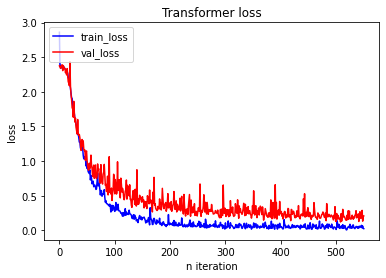

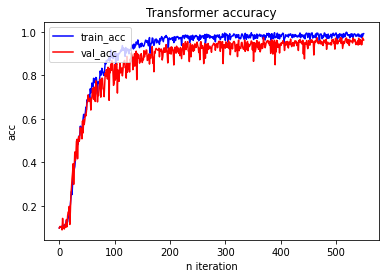

<Figure size 432x288 with 0 Axes>

In [16]:
def get_test_score_model(model, loss_fn, val_dataloader):
    #loss_history = []
    #correct_history = []
    scores_history = []
    loss_sum = 0
    correct = 0
    size = len(val_dataloader.dataset)
    num_batches = len(val_dataloader)
    model.eval()

    with torch.no_grad():
  
        for t, (x, y) in enumerate(val_dataloader):
            x = x.to(torch.float32)
            y = y.to(torch.long)
            x, y = x.to(device), y.to(device)
            scores = model(x)
            scores_history.append(scores.tolist())
            loss = loss_fn(scores, y)
            #loss_history.append(loss)
            loss_sum += loss
            correct += (scores.argmax(1) == y).type(torch.float).sum().item()

    loss_avg = loss_sum/num_batches
    correct /= size
    return loss_avg, correct, scores_history






model_name = 'transformerbest'
model_path = './CVbestmodel/' + model_name

lr = 1e-3
weight_decay = 1e-4

model = visiontransformer(embed_dim=1024, hidden_dim=1024, num_channels=3, num_heads=8, num_layers=8, num_classes=10, img_size=64, num_img=15).to(device)
model.load_state_dict(torch.load(model_path + '.pt', map_location=torch.device('cpu')))
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


train_loss_history = np.load(model_path + '_trainloss.npy')
val_loss_history = np.load(model_path + '_valloss.npy')
train_acc_history = np.load(model_path + '_trainacc.npy')
val_acc_history = np.load(model_path + '_valacc.npy')

train_loss, train_acc = train_loss_history[199], train_acc_history[199]
val_loss, val_acc = val_loss_history[199], val_acc_history[199]
test_loss, test_acc, test_scores = get_test_score_model(model, loss_fn, test_dataloader)
print(f"Train Error. Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")
print(f"Val Error. Accuracy: {(100*val_acc):>0.1f}%, Avg loss: {val_loss:>8f}")
print(f"Test Error. Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f}")

plot_curve(loss_or_acc_train=train_loss_history,loss_or_acc_val=val_loss_history, loss=True, model_name='Transformer loss')
plot_curve(loss_or_acc_train=train_acc_history,loss_or_acc_val=val_acc_history, loss=False, model_name='Transformer accuracy')

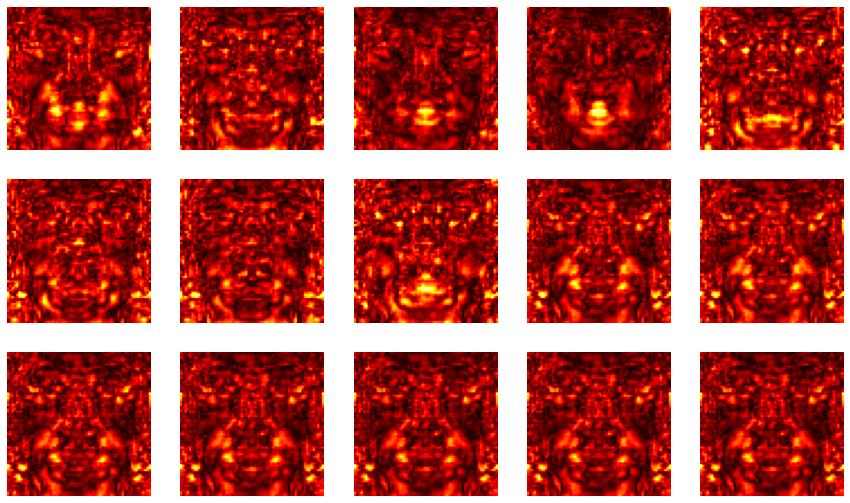

In [17]:
x_test_saliency = X_test[0]
x_test_saliency = transform_custom(x_test_saliency)
x_test_saliency = x_test_saliency.to(torch.float32)
x_test_saliency = x_test_saliency.reshape((1,15,3,64,64))
model.eval()
x_test_saliency.requires_grad_()
scores = model(x_test_saliency)
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]

score_max.backward()
saliency, _ = torch.max(x_test_saliency.grad.data.abs(),dim=2)

fig = plt.figure(figsize=(15, 9))
rows = 3
columns = 5

for i in range(15):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(saliency[0][i], cmap=plt.cm.hot)
  plt.axis('off')
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

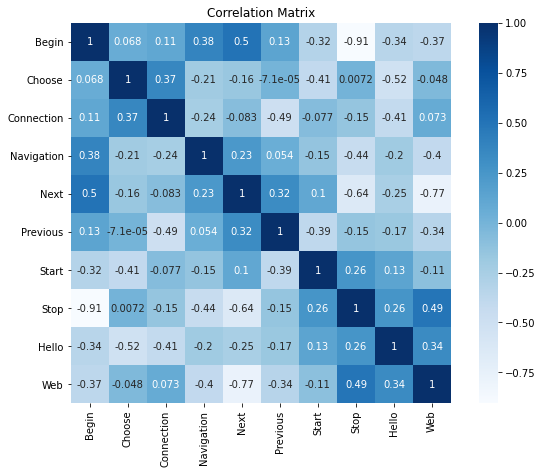

In [18]:
test_scores_re = []
for x in test_scores:
    for y in x:
        test_scores_re.append(y)
test_scores_re = np.array(test_scores_re)

corr = np.corrcoef(test_scores_re.T)
plt.subplots(figsize=(10,7))
plt.title('Correlation Matrix')
x_axis_labels = ['Begin','Choose','Connection','Navigation','Next','Previous','Start','Stop','Hello','Web'] 
y_axis_labels = ['Begin','Choose','Connection','Navigation','Next','Previous','Start','Stop','Hello','Web'] 
sns.heatmap(corr, cmap="Blues", annot=True, square=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)